# Finding Stars in Someone Else's Astronomy Homework

## Brief Background
The following example uses a single element of the NEWFIRM infrared instrument while it was mounted on the Kitt Peak 4m telescope. There are four total 2k x 2k arrays on [the NEWFIRM imager](https://noirlab.edu/science/programs/ctio/instruments/newfirm/instrument), this just uses array #2. I have already processed the raw image using darks and flats for calibration. All raw, dark, and flat files were retrieved from [NOIRLab's Astro Data Archive](https://astroarchive.noirlab.edu/). 

In [86]:
from matplotlib import pyplot as plt
import numpy as np
import sys
from scipy import ndimage
from astropy.io import fits
from astropy import wcs
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord

sys.path.append('..')

from src.astropipeline import astropipeline_etl as aple
from src.astropipeline import astropipeline_measure as aplm

### Giving Credit Where Credit Is Due

In [14]:
instcal_sample = fits.open('../../fits/k4n_150307_113502_dover.fits.fz')
hdr = instcal_sample[0].header
hdr2 = instcal_sample[2].header
img2 = instcal_sample[2].data 
img2[img2<0] = 0 # remove pixels that came back negative (even after the uniformity corrections)
instcal_sample.close()

print('Citations for the original raw image:\n')
print('--Proposal: '+hdr['PROPID'])
print('--Proposer: '+hdr['PROPOSER'])
print('--Date: '+hdr['DATE-OBS'])
print('--Target Object: '+hdr['OBJECT'])
print('--Telescope Reference Frame: '+hdr['TELRADEC'])
print('--Telescope Right Ascension and Declination: '+hdr['RA']+', '+hdr['DEC'])

Citations for the original raw image:

--Proposal: 2015A-0048
--Proposer: Herve Bouy
--Date: 2015-03-07T11:34:39.8
--Target Object: KRouleaux
--Telescope Reference Frame: FK5
--Telescope Right Ascension and Declination: 12:26:42.29, 24:58:59.6


### A Quick Investment for Efficiency
I created a histogram function to save space throughout this example. Please forgive my attempt at efficiency.

In [15]:
def myHist100(data):
    """
    Convenience function, calculates and plots 100-bin histogram

    Args:
        data (ndarray): A numpy nxm float array

    Returns:
        hist_counts (array): hist_counts per bin
        hist_bin_centers (array): bin centers
    """
    hist_counts, bin_edges = np.histogram(data, bins=100)

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    plt.bar(bin_centers, hist_counts, width=(bin_edges[1] - bin_edges[0]))

    return hist_counts, bin_centers

## Statistics of The Raw Image

The histogram below shows the distribution of pixel amplitudes following the uniformity corrections I made with my post-processing pipeline. There are clearly some aggressive outliers. Please note that I use log scaling on the y-axis for most of my histograms. When looking for features like stars against a black sky, I expect to find something like 1e6 pixels near 0 and something on the order of 1e1 pixels that are noticeably higher amplitude. Using a log scale prevents losing the one-in-a-million pixel values.

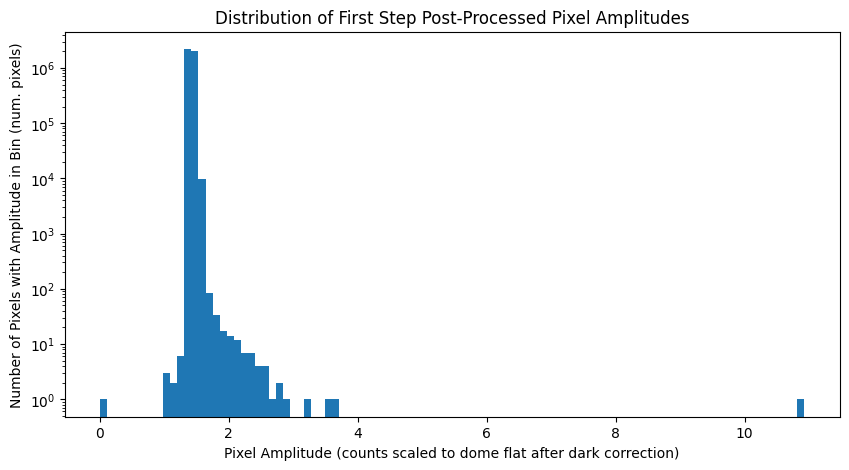

In [16]:
myHist100(img2)
plt.yscale('log')
plt.title('Distribution of First Step Post-Processed Pixel Amplitudes')
plt.xlabel('Pixel Amplitude (counts scaled to dome flat after dark correction)')
plt.ylabel('Number of Pixels with Amplitude in Bin (num. pixels)')
plt.show()

### Post-process the Process
In my image uniformity correction process, the NEWFIRM data quality mask associated with the image was used to "fix" pixels that the original processing pipeline flagged as bad. The pixels were "fixed" by replacing their values with local mean values. Even with the help of an expert-produced data quality mask, I still perform a check-and-repair process here. The output below the code shows the details of the pixels identified as problematic. 

max pixel location: 268.00, 1936.00
mean pixel value: 1.42
std of pixel value: 0.04
--current max value: 10.93
--current pixel z-score: 266.17
max pixel location: 1881.00, 405.00
mean pixel value: 1.42
std of pixel value: 0.04
--current max value: 3.65
--current pixel z-score: 62.94
min pixel location: 1753.00, 574.00
mean pixel value (global): 1.42
std of pixel value (global): 0.04
--current min value: 0.00
--current pixel z-score (global): -40.16
--current pixel z-score (local): -254.43
min pixel location: 2044.00, 1009.00
mean pixel value (global): 1.42
std of pixel value (global): 0.04
--current min value: 0.99
--current pixel z-score (global): -12.18
--current pixel z-score (local): -4.38
min pixel location: 2044.00, 1001.00
mean pixel value (global): 1.42
std of pixel value (global): 0.04
--current min value: 1.02
--current pixel z-score (global): -11.27
--current pixel z-score (local): -14.16
min pixel location: 365.00, 725.00
mean pixel value (global): 1.42
std of pixel value (

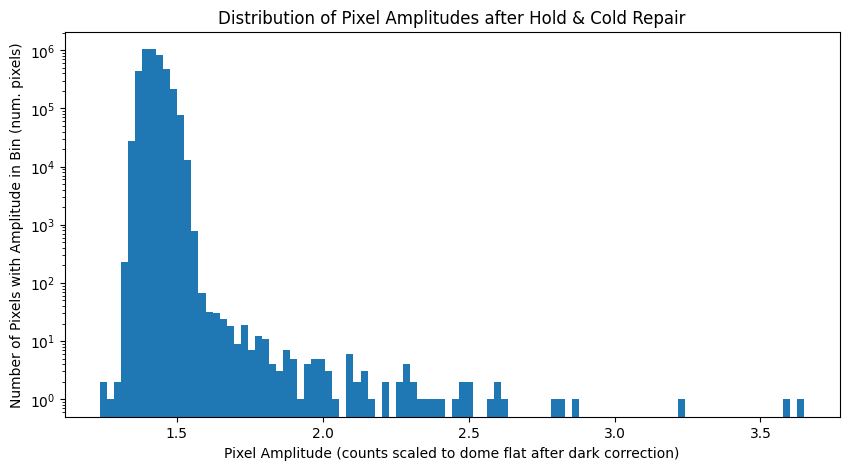

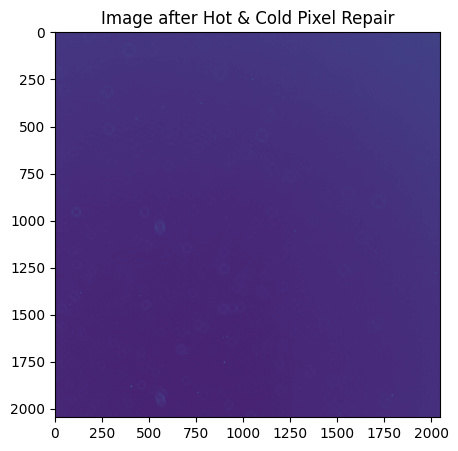

In [17]:
clean_img2 = aplm.repair_hot_pixels(img2)

clean_img2 = aplm.repair_cold_pixels(clean_img2, min_threshold=3)

plt.figure()
myHist100(clean_img2)
plt.yscale('log')
plt.title('Distribution of Pixel Amplitudes after Hold & Cold Repair')
plt.xlabel('Pixel Amplitude (counts scaled to dome flat after dark correction)')
plt.ylabel('Number of Pixels with Amplitude in Bin (num. pixels)')

plt.figure()
plt.imshow(np.log(clean_img2))
plt.title('Image after Hot & Cold Pixel Repair')
plt.show()

### Making Things "Pop"

After removing some pesky pixel problems, it's time to try basic image processing techniques to enhance the contrast of stars. I am only going to use a cropped section of the full array from above. I focus my analysis on one star (or at least what I am assuming is a star) to see how the contrast behaves.

### LoGs and DoGs
First, I am going to use the more formal Laplacian of Gaussians (LoG) approach. For people who don't normally dabble in 2D operators, the Laplacian is the second derivative across the array (the gradient's gradient). If any math experts reading this are getting nauseous right now, I'm sorry. Before applying the Laplacian operator, the image is first smoothed with a Gaussian blur filter. LoG is a multiresolution approach that can be used with successive applications of the Gaussian filter; reducing the size of the image at each step reduces the computational complexity of the problem (and conveniently allows you to use the same size Laplacian filter). Repeated applications of the Gaussian blur reduce the image resolution so that only large features stand out. Under the hood, the algorithm is effectively looking for points (or edges) of contrast that stand out at difference scales of size. Fun fact: Laplace was one of the first people to apply statistics to astronomy. 

The second approach I am going to use is the Difference of Gaussians (DoG). DoG is accomplished by blurring the original image once (I use "_gaus1" to denote this below) and then blurred again ("_gauss2"). The difference of the blurred and blurriered versions of the image effectively produces a spatial bandpass of features. Mathematically it can be shown that the result of a DoG is a computationally efficient approximation of the LoG approach. I am also including the result of performing a DoG produced at-scale (without downsampling the image via the pyramid appraoch).
<br> <br>
> *Dover's Lab doesn't have a complaints department, so if you don't like my casual phrasing:*<br>
>-- Consult Szeliski or Nayar for professional explanations of LoGs and DoGs (see [references page](https://doverslab.com/my-favorite-free-online-resources/)). <br>

<b>Note:</b> At this point I will switch from using terms like "pixel amplitude" and "pixel counts" below because the images are not images in the classical sense. They represent the output of a filtering process, so I'm using "response" to be more common with signal processing terminology.

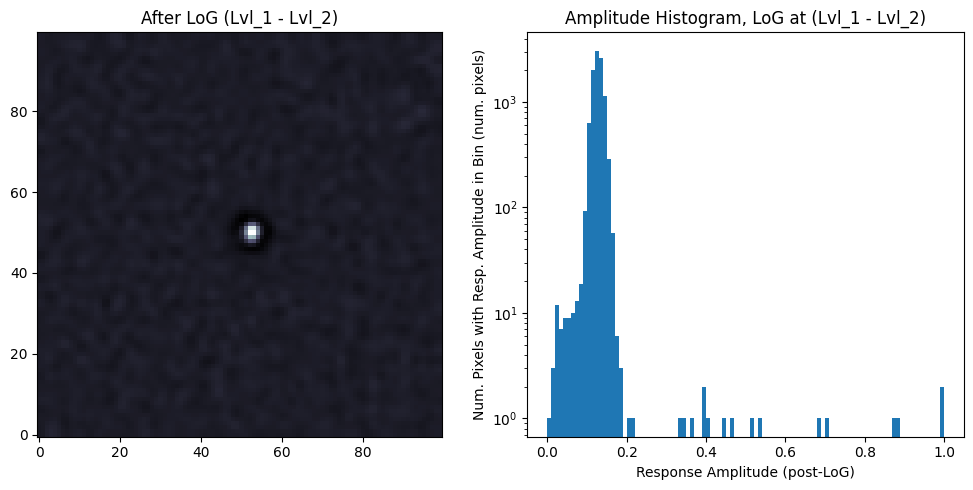

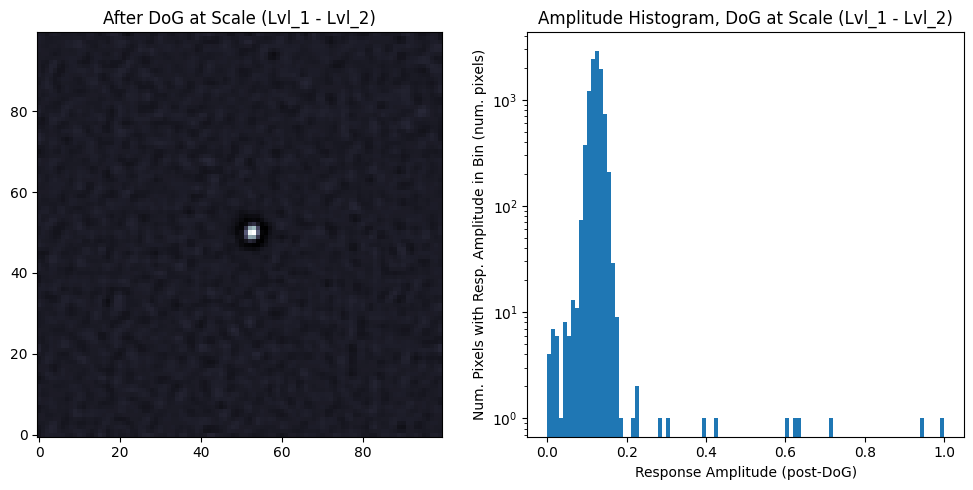

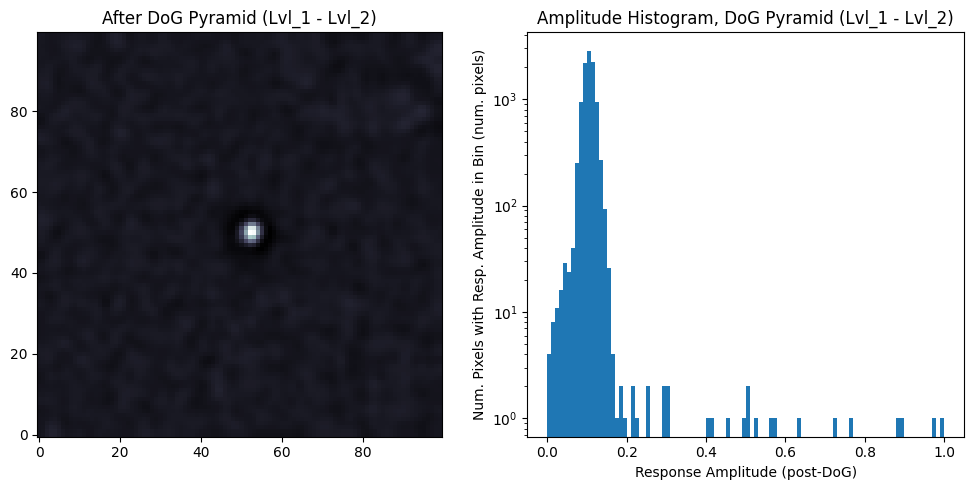

In [87]:
from skimage.transform import pyramid_gaussian, pyramid_expand, pyramid_laplacian
import time

# Crop a section around a easily visible object in the image
img2_crop = clean_img2[1350:1450,400:500].copy()

# Use the scikit_image Gaussian pyramid to get the level 1 - level 2 result
img2_gaupyr = tuple(pyramid_gaussian(img2_crop,
                                     max_layer = 2,
                                     downscale = 2,
                                     mode = 'reflect'))

dog12_result_pyr = img2_gaupyr[1] - pyramid_expand(img2_gaupyr[2],
                                                   upscale = 2)

# Expand back to original scale
dog12_result_pyr = pyramid_expand(dog12_result_pyr, upscale=2)

# Perform the DoG at the original scale (image size)
img2_gaus1 = ndimage.gaussian_filter(img2_crop,
                                     sigma = 1,
                                     mode = 'reflect')
img2_gaus2 = ndimage.gaussian_filter(img2_gaus1,
                                     sigma = 1,
                                     mode = 'reflect')
dog12_result_atscale = img2_gaus1 - img2_gaus2

# Use scikit_image LoG pyramid to the a level 1 - level 2 result
img2_logpyr = tuple(pyramid_laplacian(img2_crop,
                                      max_layer = 1,
                                      downscale = 2,
                                      mode = 'reflect'))
# Expand back to original scale
img2_log1 = pyramid_expand(img2_logpyr[1],mode='reflect')

plt.subplot(1,2,1)
plt.imshow(aplm.norm_array(img2_log1), origin='lower', cmap='bone')
plt.title('After LoG (Lvl_1 - Lvl_2)')

plt.subplot(1,2,2)
myHist100(aplm.norm_array(img2_log1))
plt.yscale('log')
plt.title('Amplitude Histogram, LoG at (Lvl_1 - Lvl_2)')
plt.xlabel('Response Amplitude (post-LoG)')
plt.ylabel('Num. Pixels with Resp. Amplitude in Bin (num. pixels)')
plt.tight_layout()
plt.show()

plt.figure()
plt.subplot(1,2,1)
plt.imshow(aplm.norm_array(dog12_result_atscale), origin='lower', cmap='bone')
plt.title('After DoG at Scale (Lvl_1 - Lvl_2)')

plt.subplot(1,2,2)
myHist100(aplm.norm_array(dog12_result_atscale))
plt.yscale('log')
plt.title('Amplitude Histogram, DoG at Scale (Lvl_1 - Lvl_2)')
plt.xlabel('Response Amplitude (post-DoG)')
plt.ylabel('Num. Pixels with Resp. Amplitude in Bin (num. pixels)')
plt.tight_layout()
plt.show()

plt.figure()
plt.subplot(1,2,1)
plt.imshow(aplm.norm_array(dog12_result_pyr), origin='lower', cmap='bone')
plt.title('After DoG Pyramid (Lvl_1 - Lvl_2)')

plt.subplot(1,2,2)
myHist100(aplm.norm_array(dog12_result_pyr))
plt.yscale('log')
plt.title('Amplitude Histogram, DoG Pyramid (Lvl_1 - Lvl_2)')
plt.xlabel('Response Amplitude (post-DoG)')
plt.ylabel('Num. Pixels with Resp. Amplitude in Bin (num. pixels)')
plt.tight_layout()
plt.show()

### Simplifying the 2-D Problem into 1-D
In the next section I am going to treat this like a classic RF signal processing problem. Rather than process the 2-D image (or a section of the image), I am going to focus on a single row of values from the 2-D image. 

To better show what the processing methods are doing to the contrast, I am going to normalize the values from each response output (on a scale of 0-1). 

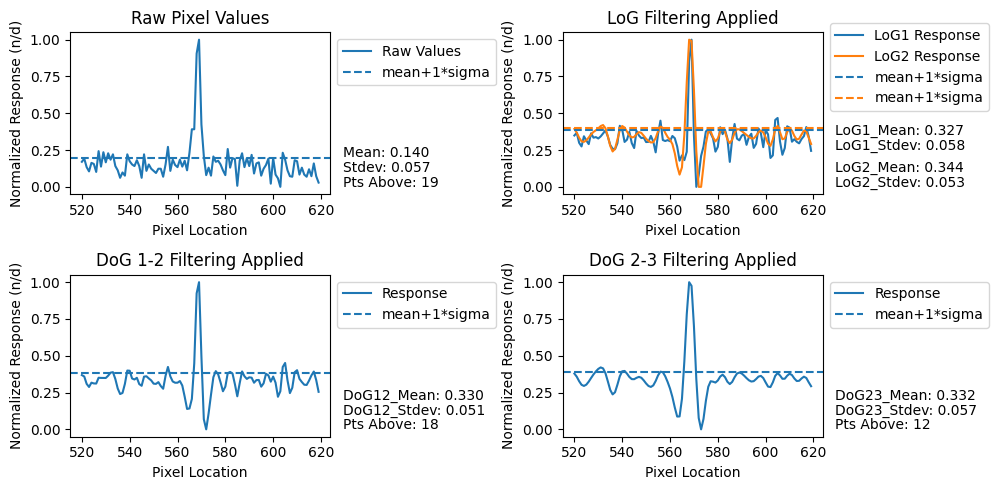

In [ ]:
# Select an object to use for the 1-D study
expected_locn = (1773,570)

# Define the window length of samples
win_len = 50

# Define the buffer length (how far away to gather background values unaffected by the object's brightness)
buff_len = 5

# Definte the spatial locations of the 1-D Samples
x_vals = range(expected_locn[1]-win_len,expected_locn[1]+win_len,1)

# Retrieve the corresponding sample values
pixel_row = img2[expected_locn[0],x_vals]

# Apply a 1-D DoG between the 1st and 2nd blur applications
dog12_row_result = aplm.dog_1d(pixel_row, sigma_hi=1, sigma_lo=2)

# Apply a 1-D DoG between the 2nd and 3rd blur applications
dog23_row_result = aplm.dog_1d(pixel_row, sigma_hi=2, sigma_lo=3)

# Get the background stats for the normalized Level 1-2 result
dog12_norm_bg_vals = aplm.background_sample_1d(
                                         aplm.norm_array(dog12_row_result),
                                         exp_locn=(expected_locn[1]-x_vals[0]),
                                         buffer_len=5
                                         )

# Get the background stats for the normalized Level 2-3 result
dog23_norm_bg_vals = aplm.background_sample_1d(aplm.norm_array(dog23_row_result),
                                         exp_locn=(expected_locn[1]-x_vals[0]),
                                         buffer_len=5
                                         )

plt.rcParams['figure.figsize'] = [10, 5]
plt.figure()
plt.subplot(2,2,1)
raw_plot, = plt.plot(x_vals,aplm.norm_array(pixel_row),label='Raw Values')

norm_bg_vals = aplm.background_sample_1d(aplm.norm_array(pixel_row),
                                         exp_locn=(expected_locn[1]-x_vals[0]),
                                         buffer_len=5)

plt.axhline(norm_bg_vals[0]+norm_bg_vals[1],
            linestyle='--',
            color=raw_plot.get_color(),
            label='mean+1*sigma')

plt.title('Raw Pixel Values')
plt.ylabel('Normalized Response (n/d)')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.text(np.max(x_vals)+10,.2,"Mean: {:.3f}".format(norm_bg_vals[0]))
plt.text(np.max(x_vals)+10,.1,"Stdev: {:.3f}".format(norm_bg_vals[1]))
plt.text(np.max(x_vals)+10,.0,"Pts Above: {:d}".format(
    np.sum(aplm.norm_array(pixel_row) > np.sum(norm_bg_vals))
    ))
plt.xlabel('Pixel Location')
plt.subplot(2,2,2)
log1_row_result = -ndimage.laplace(
                    ndimage.gaussian_filter1d(pixel_row,sigma=1,mode='reflect')
                    )
log2_row_result = -ndimage.laplace(
                    ndimage.gaussian_filter1d(pixel_row,sigma=2,mode='reflect')
                    )

log1_norm_bg_vals = aplm.background_sample_1d(aplm.norm_array(log1_row_result),
                                         exp_locn=(expected_locn[1]-x_vals[0]),
                                         buffer_len=5
                                         )

log2_norm_bg_vals = aplm.background_sample_1d(aplm.norm_array(log2_row_result),
                                         exp_locn=(expected_locn[1]-x_vals[0]),
                                         buffer_len=5
                                         )

plog1, = plt.plot(x_vals,aplm.norm_array(log1_row_result),
                   label='LoG1 Response')
plog2, = plt.plot(x_vals,aplm.norm_array(log2_row_result),
                   label='LoG2 Response')

plt.axhline(log1_norm_bg_vals[0]+\
            log1_norm_bg_vals[1],
            linestyle='--',
            color=plog1.get_color(),
            label='mean+1*sigma')

plt.axhline(log2_norm_bg_vals[0]+\
            log2_norm_bg_vals[1],
            linestyle='--',
            color=plog2.get_color(),
            label='mean+1*sigma')

plt.title('LoG Filtering Applied')
plt.ylabel('Normalized Response (n/d)')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.1))
plt.text(np.max(x_vals)+10,.35,"LoG1_Mean: {:.3f}".format(log1_norm_bg_vals[0]))
plt.text(np.max(x_vals)+10,.25,"LoG1_Stdev: {:.3f}".format(log1_norm_bg_vals[1]))
plt.text(np.max(x_vals)+10,.1,"LoG2_Mean: {:.3f}".format(log2_norm_bg_vals[0]))
plt.text(np.max(x_vals)+10,.0,"LoG2_Stdev: {:.3f}".format(log2_norm_bg_vals[1]))
plt.xlabel('Pixel Location')

plt.subplot(2,2,3)
pdog12, = plt.plot(x_vals,aplm.norm_array(dog12_row_result),
                   label='Response')
plt.axhline(dog12_norm_bg_vals[0]+\
            dog12_norm_bg_vals[1],
            linestyle='--',
            color=pdog12.get_color(),
            label='mean+1*sigma')

plt.title('DoG 1-2 Filtering Applied')
plt.ylabel('Normalized Response (n/d)')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.text(np.max(x_vals)+10,.2,"DoG12_Mean: {:.3f}".format(dog12_norm_bg_vals[0]))
plt.text(np.max(x_vals)+10,.1,"DoG12_Stdev: {:.3f}".format(dog12_norm_bg_vals[1]))
plt.text(np.max(x_vals)+10,.0,"Pts Above: {:d}".format(
    np.sum(aplm.norm_array(dog12_row_result) > np.sum(dog12_norm_bg_vals))
    ))
plt.xlabel('Pixel Location')

plt.subplot(2,2,4)
pdog23, = plt.plot(x_vals,aplm.norm_array(dog23_row_result),
                   label='Response')
plt.axhline(dog23_norm_bg_vals[0]+\
            dog23_norm_bg_vals[1],
            linestyle='--',
            color=pdog23.get_color(),
            label='mean+1*sigma')

plt.title('DoG 2-3 Filtering Applied')
plt.ylabel('Normalized Response (n/d)')
plt.xlabel('Pixel Location')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.text(np.max(x_vals)+10,.2,"DoG23_Mean: {:.3f}".format(dog23_norm_bg_vals[0]))
plt.text(np.max(x_vals)+10,.1,"DoG23_Stdev: {:.3f}".format(dog23_norm_bg_vals[1]))
plt.text(np.max(x_vals)+10,.0,"Pts Above: {:d}".format(
    np.sum(aplm.norm_array(dog23_row_result) > np.sum(dog23_norm_bg_vals))
    ))
plt.tight_layout()
plt.show()

dog12_snr = (1-dog12_norm_bg_vals[0])/dog12_norm_bg_vals[1]
dog23_snr = (1-dog23_norm_bg_vals[0])/dog23_norm_bg_vals[1]


#### *Some things to notice in the plots above:*
-  The raw pixel mean-plus-one-sigma value is lower than the processed distributions. This could be thought of as a lower *relative* noise floor.
-  While the difference between the peak and the mean values (AKA signal or "effective contrast") might decrease in the processed results, the number of random peaks above the mean-plus-one-sigma threshold also decreases (decreased false positives).  

### Contrast vs Significance <br>
After noticing the reduced *contrast* in the responses, the logical question is "why do it?". The benefit of LoGs and DoGs has nothing to do with measurement; it's all about locating features. The smoothing operations just highlight valid features and suppress noise. For more information about smoothing considerations in localization and measuring applications, I recommend [O'Haver's Intro to Signal Processing, pages 49-50](https://terpconnect.umd.edu/~toh/spectrum/IntroToSignalProcessing.pdf#page=24). <br><br>

> #### "Valid" features? Who are you to determine what's valid?! <br>
> Great question, author. LoGs and DoGs both start by applying Gaussian (blurring) filters to the image. Any image taken with a real camera (or "imager" for astronomy) will have a non-zero amount of blur regardless of how crisp the outside scene may be. The camera blur is not the subject of this notebook, but please check out [Nayar's Image Processing Slides (specifically #9-10)](https://cave.cs.columbia.edu/Statics/monographs/Image%20Processing%201%20FPCV-1-4.pdf). <br>
Once you accept the inevitability of the blur, you will realize that it can be useful. Pixel readings may be noisy, but real features (impulses) from the outside world will have a predictable blur. Structuring a filter (shaping the Gaussian) based on a known system response is known as <b>matched filtering</b>. LoGs and DoGs work because they are matched filters for specific sizes of features.<br><br>
*Calm down, physicists. Yes, the diffraction blur is actually a sinc function. The Gaussian shape is used as an approximation of it. The Airy Disk is also an approximation. Don't hate the player...*

### Relative vs Absolute Filter Response

The figures below are the outputs of DoG filtering at increasing scale (bigger blurring --> lower resolution). The plots are broken up as follows:
 - A single 2-D response representing the post-filter response. The viridis colormap is used to exaggerate contrast.
 - A combined plotting of the **normalized** 2-D response (the values of the specific array are normalized 0-1) along with a histogram of the normalized values.

The color scaling for the unnormalized (viridis-colored) plots is the same scale across all plots. This is intentional. It helps to show the decreasing amplitudes of responses as the scale (Gaussian size) increases. The response at the location of the star in the DoG 0-1 plot is the highest; by the DoG 3-4 plot it is barely visible. Looking at the corresponding normalized plots and histrograms, it should be easier to see that as the raw response of the star gets dimmer at larger scales, other features appear to be increasing in relative amplitude. 

In signal processing terms, the signal in the "bigger" filters (band-passes) is getting smaller. The SNR is also decreasing. When plots are scaled to the maximum in-band signal, the noise appears more significant. 

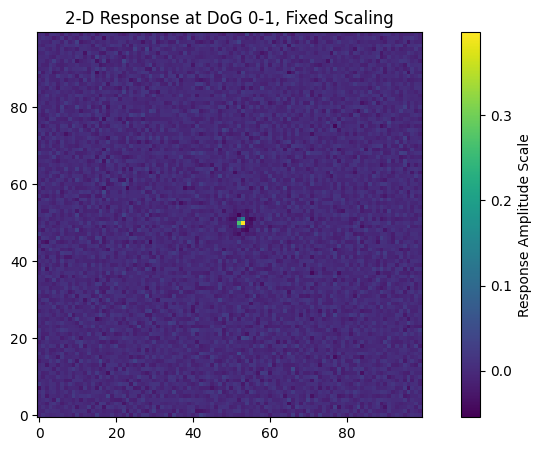

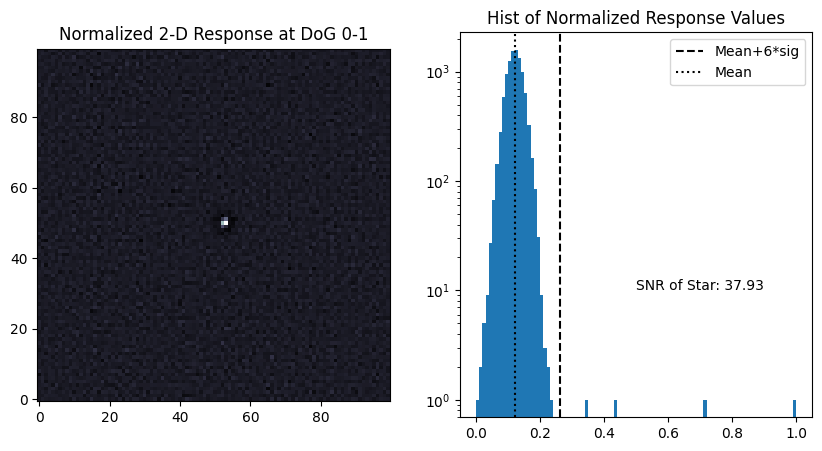

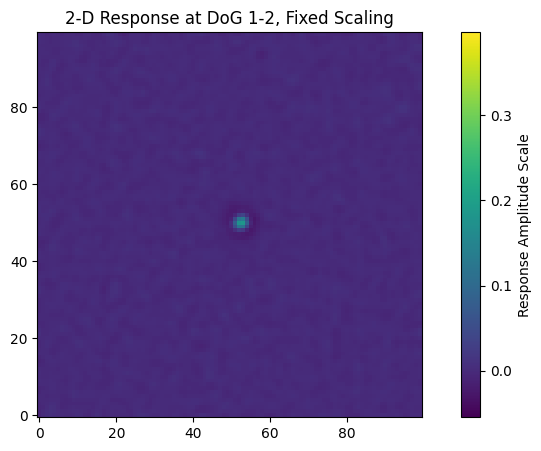

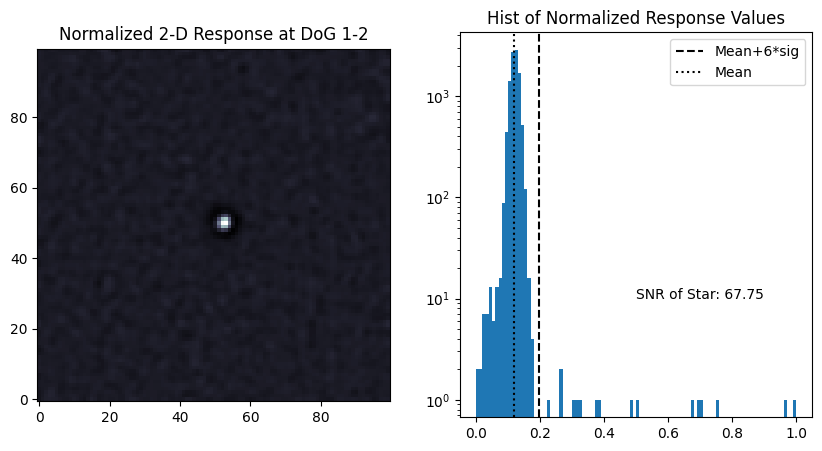

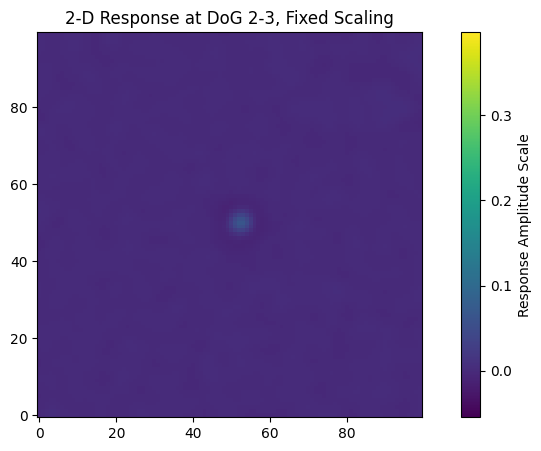

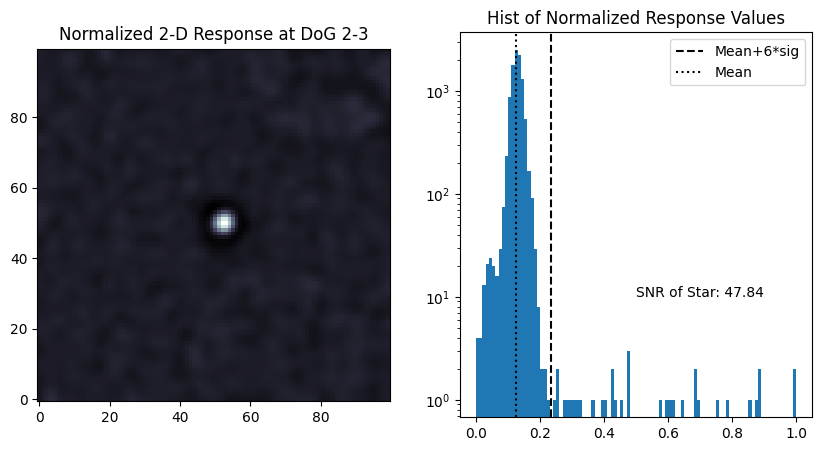

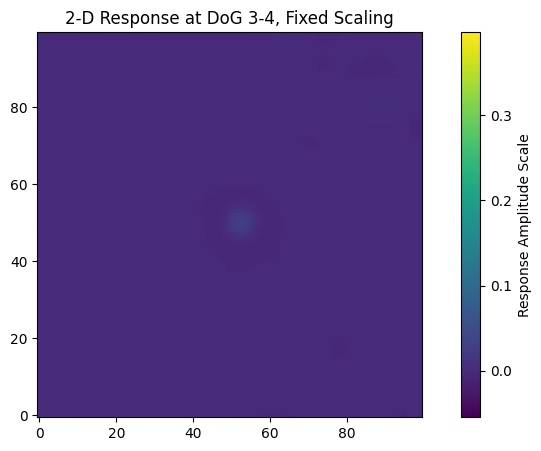

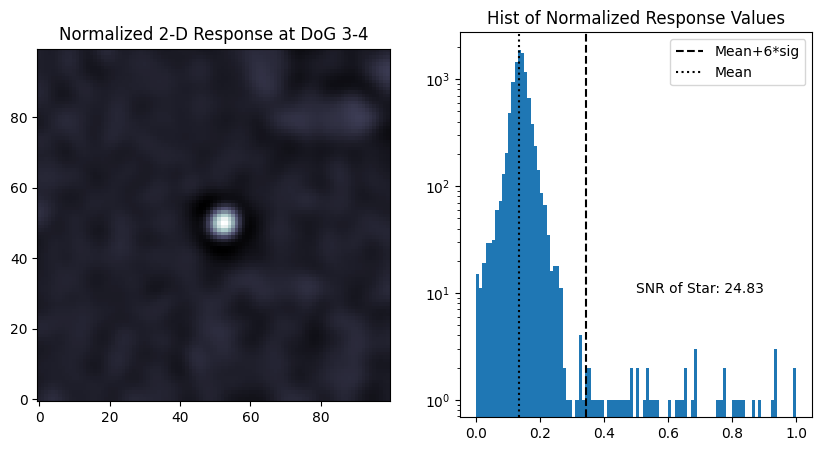

In [ ]:
# Crop the image around a clean, easily identifiable object
img2_crop = clean_img2[1350:1450,400:500]

# Grab the row and column of the maximum value
max_row, max_col = np.unravel_index(
    np.argmax(img2_crop.flatten()),
    img2_crop.shape)

# Initialize the best level and SNR values
best_lvl = -1
best_snr = 0

# Initialize the min and max amplitudes for scaling plots
min_max_amplitudes = []

# Loop over each level of DoG twice (the first loop finds the min-max values)
for i in range(0,2,1):
    for lvl in range(0,4,1):

        # Grab the bandpass result
        crop_dog_lvl = aplm.dog_2d(img2_crop,
                                    sigma_hi=lvl,
                                    sigma_lo=(lvl+1),
                                    mode='reflect'
                                    )

        # Grab the min and max values on the first loop, use them to scale on the second 
        if i == 0:
            min_max_amplitudes.append([np.min(crop_dog_lvl),np.max(crop_dog_lvl)])
            continue

        # Get the normalized response array
        crop_dog_lvl_norm = aplm.norm_array(crop_dog_lvl)

        # Calculate the background stats
        bg_stats_lvl = aplm.background_sample_2d(crop_dog_lvl_norm, (max_row, max_col), (5,5))

        # Calculate the SNR as the statistical Z-score on the normalized array
        lvl_snr = (1-bg_stats_lvl[0])/bg_stats_lvl[1]

        # Store the best score and level
        if lvl_snr > best_snr: 
            best_snr = lvl_snr
            best_lvl = lvl
        
        plt.figure()        
        implot = plt.imshow(crop_dog_lvl,
                vmin=np.min([row[0] for row in min_max_amplitudes]),
                vmax=np.max([row[1] for row in min_max_amplitudes]),
                cmap='viridis',
                origin='lower'
                )
        plt.colorbar(implot, label='Response Amplitude Scale')
        plt.title(
                '2-D Response at DoG {:d}-{:d}, Fixed Scaling'.format(lvl,lvl+1)
                )

        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(crop_dog_lvl_norm,
                cmap='bone',
                origin='lower'
                )
        plt.title(
                'Normalized 2-D Response at DoG {:d}-{:d}'.format(lvl,lvl+1)
                )

        plt.subplot(1,2,2)
        _,_ = myHist100(crop_dog_lvl_norm)
        plt.axvline(bg_stats_lvl[0]+6*bg_stats_lvl[1], 
                    linestyle='--',
                    color='black',
                    label='Mean+6*sig',
                    )
        plt.axvline(bg_stats_lvl[0], 
                    linestyle=':',
                    color='black',
                    label='Mean',
                    )
        plt.yscale('log')
        plt.legend()
        plt.title('Hist of Normalized Response Values')
        plt.text(0.5,10,
                "SNR of Star: {:.2f}". 
                format(lvl_snr)
                )

        plt.show()
    



The 2-D response and corresponding histogram below show another chunk of sky going through the DoG layer (bandpass) that produced the highest SNR on the test star above. This has been included to help understand how tuning the filtering process on one impulse can be used elsewhere. 

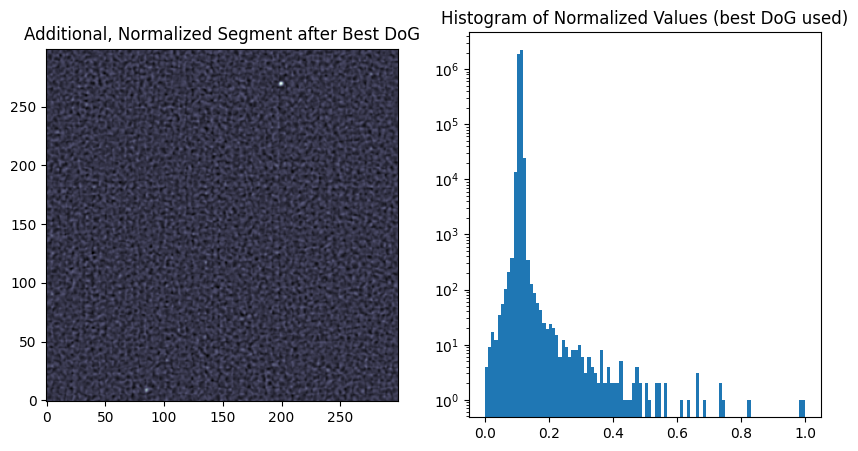

In [ ]:
# Apply the highest SNR DoG to the entire image
best_dog_lvl = aplm.norm_array(
                aplm.dog_2d(clean_img2,
                            sigma_hi=best_lvl,
                            sigma_lo=(best_lvl+1),
                            mode='reflect'
                            )
                )

plt.subplot(1,2,1)
plt.imshow(best_dog_lvl[600:900,600:900], cmap='bone', origin='lower')
plt.title('Normalized Segment after Best DoG')

plt.subplot(1,2,2)
_,_ = myHist100(best_dog_lvl)
plt.title('Hist. of Normalized Values (best DoG used)')
plt.yscale('log')
plt.show()

## When Does Measurement Happen?

Previously in this post I mention that all of the filtering is a <u>localization</u> tool, but the filtered result is not what should be <u>measured</u>. Following the general process defined by O'Haver, I use the best SNR DoG result to locate the strongest filter responses and then use that as an initial guess for where to measure the (unfiltered) pixel values from my original processing of the NEWFIRM #2 imaging array. Assuming that my processing pipeline produced calibrated pixel values, the measurement hereafter would be generating peak flux and total integrated flux observed by NEWFIRM.

The first [unofficial] step I take is making sure that the point I'm about to study is spatially unique from previously analyzed points. I did not analytically calculate the point spread function before starting this section, so determining the spatial tolerance for "unique" points was done iteratively. The same is true for determining the "extent" of pixels to crop out. 

The second step is using the background pixel values near the star/object to set a threshold. Values significantly above that threshold will be used to find the centroid of the star. If the thresholding weren't accomplished, the centroid would be biased by the raw shape of the cropped section. The threshold-and-centroid process produces a subpixel coordinate for the center of the star/object. 

The final step is calculating the distance from every measured pixel value to the centroid location then plotting the pixel values vs the pixel distance. If the point of interest is indeed an external, bright object (as opposed to a hot pixel) the resulting plot will look like half of a Gaussian curve. This is a direct represenation of the point spread function. I learned this approach while watching [Richard Berry's "How to Understand Star Photometry"](https://www.youtube.com/watch?v=ufbFaUywEBg&t=6878s) on the American Association of Variable Star Observers (AAVSO) YouTube page.

Rmax=2.00, Cmax=2.00
Rcent=6.48, Ccent=4.42


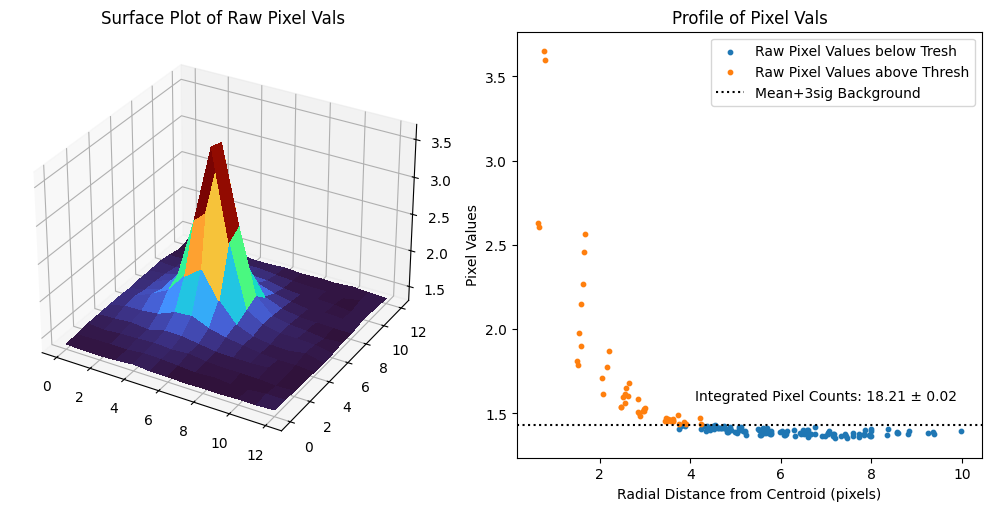

Rmax=2.00, Cmax=2.00
Rcent=5.87, Ccent=5.71


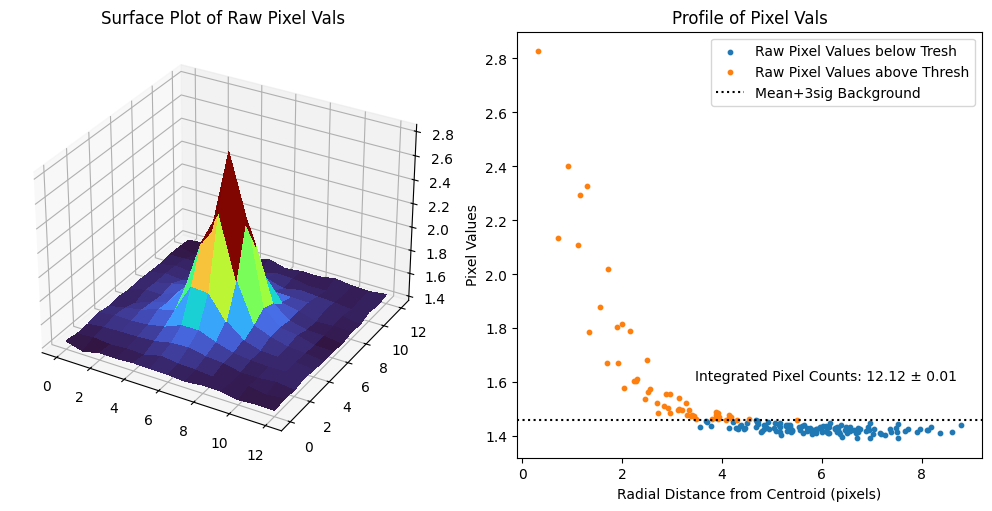

Rmax=2.00, Cmax=2.00
Rcent=5.02, Ccent=5.91


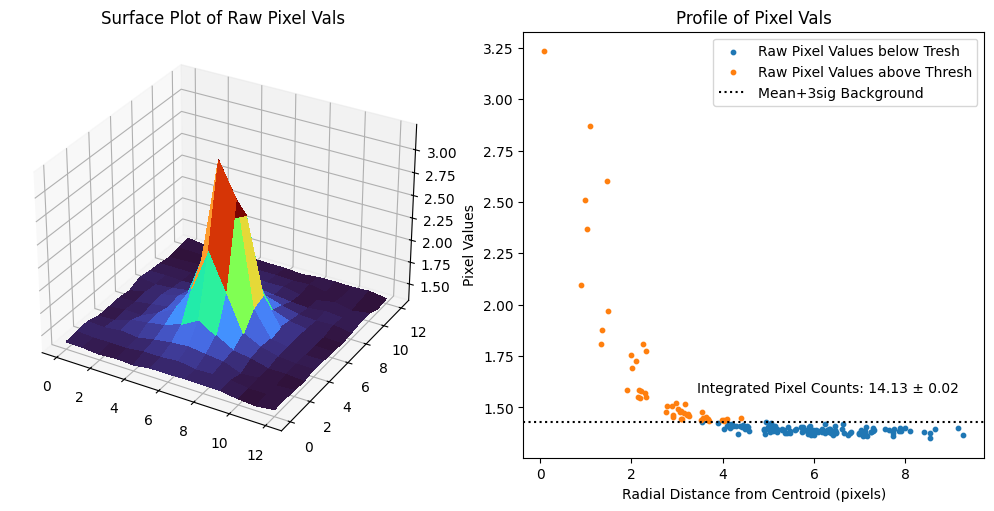

In [98]:
# Define the extent for how many pixels to crop out around the point of interest
extent = [6,6]

# Find the top 10 strongest responses in the best DoG
rmax_dog, cmax_dog = np.unravel_index(
    np.argsort(best_dog_lvl.flatten())[-10:],
    best_dog_lvl.shape)

# Loop over the 10 strongest responses
for i in range(0,len(rmax_dog),1):

    # After the first point, make sure the next points aren't part of a previous object
    if i > 0: 
        l2_dist = np.linalg.norm(
            np.array(
                [rmax_dog[0:i]-rmax_dog[i],
                 cmax_dog[0:i]-cmax_dog[i]]
                   ),
                   axis=0)
        if np.min(l2_dist) < 2*np.max(extent):
            continue

    # Crop out the values around the point of interest
    local_pixels_raw = aplm.get_adjacent_pixels(img2,
                                                (rmax_dog[i], cmax_dog[i]),
                                                extent=extent,
                                                remove_mid=False)  

    # Get a statistical measurement of the local background
    border_stats = aplm.get_border_stats(local_pixels_raw)

    # Set a threshold based on the background stats
    thresh = border_stats[0]+3*border_stats[1]

    # Mask the pixels above the threshold
    mask = np.ma.masked_where(local_pixels_raw>=thresh,
                            local_pixels_raw)

    # Set the pixels below the threshold to zero before the centroid calc
    mask.data[mask.mask==False] = 0

    # Estimate the object's centroid
    centroid_locn = aplm.get_centroid(mask.data, extent=-1)
    
    # Compute the pixel distances from the centroid
    pix_distances, X, Y = aplm.get_pix_distances(local_pixels_raw,
                                                exp_locn=(
                                               centroid_locn[0],
                                               centroid_locn[1]
                                               )
                                               )

    # Calculate the integrated counts
    integrated_counts = np.sum(local_pixels_raw[mask.mask==True]-border_stats[0])

    print("Rmax={:.2f}, Cmax={:.2f}".format(2,2))
    print("Rcent={:.2f}, Ccent={:.2f}".format(centroid_locn[0],centroid_locn[1]))

    plt.figure(layout='constrained')
    ax = plt.subplot(1,2,1,projection='3d')
    ax.plot_surface(X, Y, local_pixels_raw, cmap='turbo', linewidth=0, antialiased=False)
    plt.title('Surface Plot of Raw Pixel Vals')
    
    plt.subplot(1,2,2)
    plt.scatter(np.abs(np.ravel(pix_distances[mask.mask==False])),
                np.ravel(local_pixels_raw[mask.mask==False]),
                s=10,
                label='Raw Pixel Values below Tresh')
    plt.scatter(np.abs(np.ravel(pix_distances[mask.mask==True])),
                np.ravel(local_pixels_raw[mask.mask==True]),
                s=10,
                label='Raw Pixel Values above Thresh')
    plt.axhline(thresh,
                linestyle=':',
                color='black',
                label='Mean+3sig Background')
    plt.title('Profile of Pixel Vals')
    plt.xlabel('Radial Distance from Centroid (pixels)')
    plt.ylabel('Pixel Values')
    plt.text(np.max(pix_distances),1.1*thresh, 
        'Integrated Pixel Counts: {:.2f} \u00B1 {:.2f} '. 
        format(integrated_counts, border_stats[1]),
        ha='right',
        )
    
    plt.legend()
    plt.show()
